In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from sklearn.neural_network import MLPClassifier

# Define a neural network classifier with default parameters
model = MLPClassifier()

In [13]:
# prompt: Import train_splits.pickle and call what is inside train_splits

import pickle

with open('train_splits.pickle', 'rb') as f:
  split_data = pickle.load(f)

with open('train_test_data.pickle', 'rb') as file:
  train_test_split = pickle.load(file)


X_train_raw = train_test_split['X_train_raw']
y_train_raw = train_test_split['y_train_raw']
X_test_raw = train_test_split['X_test_raw']
y_test_raw = train_test_split['y_test_raw']


In [3]:
X_train, X_val, y_train, y_val = split_data["random"]

In [14]:
from sklearn.metrics import make_scorer, recall_score
# Define a custom scorer for recall of the positive class (class 1.0)
recall_scorer = make_scorer(recall_score, pos_label=1)

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint



# Define the parameter distribution
param_dist = {
    'hidden_layer_sizes': [(randint(3, 256).rvs(), randint(3, 256).rvs())],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': uniform(0.0001, 0.01),
    'learning_rate': ['constant', 'adaptive']
}

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=5, scoring=recall_scorer, n_jobs=-1, verbose=3, random_state=42)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best recall score: ", random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'activation': 'relu', 'alpha': 0.0061111501174320884, 'hidden_layer_sizes': (226, 108), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best recall score:  0.5528185328185329


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [8]:
best_params_=random_search.best_params_

In [9]:
model = MLPClassifier(**best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


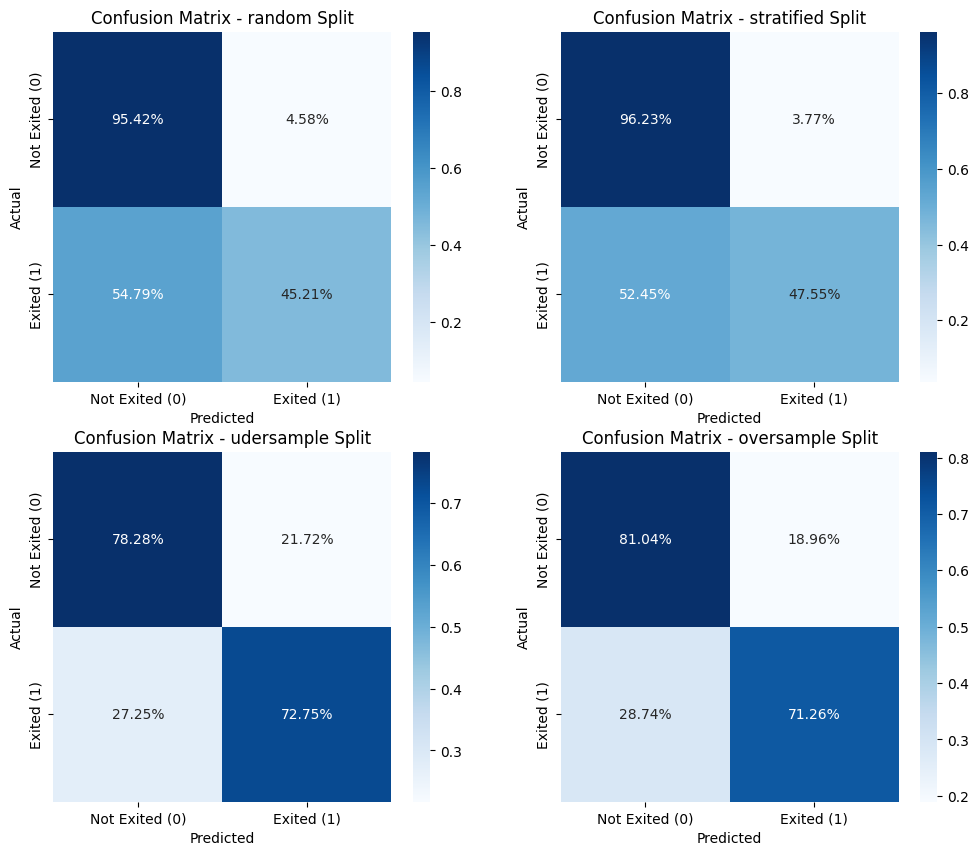

<Figure size 800x600 with 0 Axes>

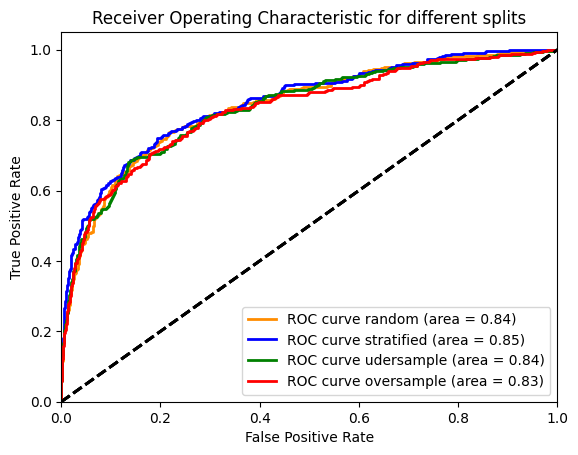

In [10]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
performance = {}
def evaluating_perfromance_diff_splits(model=model,split_data=split_data,performance_matrix=performance):
    #Create a 2x2 grid for confusion matrices
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    plt.figure(figsize=(8,6))
    plt.figure()
    colors = ['darkorange', 'blue', 'green', 'red']
    # Loop through the splits in split_data
    for i, split in enumerate(split_data):
        X_train, X_val, y_train, y_val =split_data[split]
        # Train the model
        model.fit(X_train, y_train)

        # Predict probabilities for the test set
        y_score = model.predict_proba(X_val)[:, 1]

        # Predict our target variable
        y_val_pred = model.predict(X_val)
        # Compute ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_val, y_score)
        roc_auc = auc(fpr, tpr)
        #Calculate balanced accuracy
        balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
        # Generate classification report
        report = classification_report(y_val, y_val_pred)
        # Extract metrics from classification report
        report_dict = classification_report(y_val, y_val_pred, output_dict=True)
        #Plot the confusion matrix for the teset set
        conf_matrix = confusion_matrix(y_val, y_val_pred)
        tn, fp, fn, tp = conf_matrix.ravel()
        #Normalize the confusion matrix by the number of true samples per class
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

        sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[i],
                    xticklabels=['Not Exited (0)', 'Exited (1)'],
                    yticklabels=['Not Exited (0)', 'Exited (1)'])
        axes[i].set_title(f'Confusion Matrix - {split} Split')
        axes[i].set_ylabel('Actual')
        axes[i].set_xlabel('Predicted')
        performance_matrix[split] = {
            'precision': report_dict['1']['precision'],
            'recall': report_dict['1']['recall'],
            'f1-score': report_dict['1']['f1-score'],
            'support': report_dict['1']['support'],
            'roc_auc': roc_auc,
            'balanced_accuracy': balanced_acc
        }


        # Plot ROC curve
        plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'ROC curve {split} (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for different splits')
        plt.legend(loc="lower right")
    plt.show()
    return performance_matrix

performance = evaluating_perfromance_diff_splits(model=model,split_data=split_data,performance_matrix=performance)

In [11]:
performance_df = pd.DataFrame(performance).T
performance_df

,precision,recall,f1-score,support,roc_auc,balanced_accuracy
random,0.722488,0.452096,0.556169,334.0,0.840726,0.703141
stratified,0.763547,0.475460,0.586011,326.0,0.850375,0.718892
udersample,0.469112,0.727545,0.570423,334.0,0.835639,0.755163
oversample,0.497908,0.712575,0.586207,334.0,0.831087,0.761501


In [ ]:
# prompt: write code to maximise scorer_recall using optuna on my model on the X_train and Y_train data

!pip install optuna

import optuna
from sklearn.metrics import recall_score

def objective(trial):
    """Objective function for Optuna optimization."""

    # Define the hyperparameters to be optimized
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [(100,), (50, 50), (100, 50)])
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd'])
    alpha = trial.suggest_float('alpha', 1e-5, 1e-1, log=True)
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'adaptive', 'invscaling'])

    # Create the model with the suggested hyperparameters
    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        alpha=alpha,
        learning_rate=learning_rate,
        random_state=42  # Set a random state for reproducibility
    )

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred = model.predict(X_val)

    # Calculate the recall score
    recall = recall_score(y_val, y_pred, pos_label=1)

    return recall

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=100)  # You can adjust n_trials as needed

# Print the best hyperparameters and the best recall score
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

# Train the model with the best hyperparameters
best_params = trial.params
best_model = MLPClassifier(**best_params)
best_model.fit(X_train, y_train)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.6 MB/s eta 0:00:00


[I 2024-10-21 22:33:23,904] A new study created in memory with name: no-name-5d3b585a-3d65-4a68-9747-0589dfd42925
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 50) which is of type tuple.
  warnings.warn(message)
[I 2024-10-21 22:33:29,685] Trial 0 finished with value: 0.011976047904191617 and para